<a href="https://colab.research.google.com/github/JoshuaShunk/NSDropout/blob/main/mnist_implementation_of_New_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Numbers Implementation of My New Layer

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import keras
from keras.datasets import mnist
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import statistics

In [2]:
np.set_printoptions(threshold=np.inf)

In [3]:
np.random.seed(seed=22) #Random seed used for comparison between old dropout

In [4]:
print(np.random.random(size=3)) #Check that seeds line up

[0.20846054 0.48168106 0.42053804]


In [5]:
a = np.array([1,0,0,1,1,1])
b = np.array([1,0,1,1,0,1])
count = 0
for i, j in zip(a,b):
  if i != j:
    count += 1

print(count)
print(f'Difference: {np.count_nonzero(a==b)}')

2
Difference: 4


In [6]:
#@title Load Layers (Credit to Harrison Kinsley & Daniel Kukiela for raw python implementation)

# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

# ReLU activation


class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters

    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
                             (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + \
                           (1 - self.rho) * layer.dbiases ** 2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.02, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
                                     (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
                                   (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
                             (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
                           (1 - self.beta_2) * layer.dbiases ** 2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
                                 (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
                               (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                          self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        bias_momentums_corrected / \
                        (np.sqrt(bias_cache_corrected) +
                         self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:


    # Regularization loss calculation
    def regularization_loss(self, layer):

        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                   np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                   np.sum(layer.weights *
                                          layer.weights)

        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                   np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                   np.sum(layer.biases *
                                          layer.biases)

        return regularization_loss


    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

    # Calculates accumulated loss
    def calculate_accumulated(self, *, include_regularization=False):

        # Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Reset variables for accumulated loss
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

        # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

# Common accuracy class
class Accuracy:

    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):

        # Get comparison results
        comparisons = self.compare(predictions, y)

        # Calculate an accuracy
        accuracy = np.mean(comparisons)

        # Add accumulated sum of matching values and sample count
        # Return accuracy
        return accuracy

    # Calculates accumulated accuracy
    def calculate_accumulated(self):

        # Calculate an accuracy
        accuracy = self.accumulated_sum / self.accumulated_count

        # Return the data and regularization losses
        return accuracy

    # Reset variables for accumulated accuracy
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y


# Accuracy calculation for regression model
class Accuracy_Regression(Accuracy):

    def __init__(self):
        # Create precision property
        self.precision = None

    # Calculates precision value
    # based on passed-in ground truth values
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision

class model:
    def __init__(self):
        pass

    def predict(self, classes, samples):
        self.classes = classes
        self.samples = samples
        self.X, self.y = spiral_data(samples=self.samples, classes=self.classes)
        dense1.forward(self.X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        # Calculate the data loss
        self.loss = loss_function.calculate(activation2.output, self.y)
        self.predictions = (activation2.output > 0.5) * 1
        self.accuracy = np.mean(self.predictions == self.y)
        print(f'Accuracy: {self.accuracy}')




# Old Dropout Layer

In [7]:
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                                              size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask
       

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask
        #print(self.dinputs.shape)

# New Dropout Layers

In [8]:
class Layer_BinaryNSDropout:

    # Init
    def __init__(self, rate):
        self.rate = 1 - rate
        self.iterations = 0

    def forward(self, inputs, val_inputs):
        self.inputs = inputs
        self.val_inputs = val_inputs
        nummask = round(len(self.inputs[0]) * self.rate)
        
        #Averaging Values
        self.meanarray1 = np.mean(inputs, axis=0)
        self.meanarray2 = np.mean(val_inputs, axis=0)

        if self.iterations != 0:
            # Calculating value
            self.difference = self.meanarray1 - self.meanarray2
            ind = np.argpartition(self.difference, -nummask)[-nummask:]
            mask = np.ones(self.meanarray1.shape, dtype=bool)
            mask[ind] = False
            self.difference[~mask] = 1
            self.difference[mask] = 0. 
            self.binary_mask = self.difference / self.rate

        else:
            self.binary_mask = np.random.binomial(1, self.rate,
                                                  size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

    def post_update_params(self):
        self.iterations += 1

In [9]:
class Layer_CatagoricalNSDropout:

    # Init
    def __init__(self, rate):
        self.rate = rate
        self.iterations = 0


    def forward(self, X_test, y_test, X, y):        
        if self.iterations != 0:
          #Adding sorted data into dictionaries 
          sorted_x = {}
          sorted_y = {}
          for classes in range(len(set(y))):
            sorted_x["class_{0}".format(classes)] = X[y == classes]
            sorted_y["label_{0}".format(classes)] = y[y == classes]

          sorted_x_test = {}
          sorted_y_test = {}
          for classes in range(len(set(y))):
            sorted_x_test["class_{0}".format(classes)] = X_test[y_test == classes]
            sorted_y_test["label_{0}".format(classes)] = y_test[y_test == classes]

          #Averaging sorted data from each class then finding the difference between the averaged train and test inputs
          differnce_classes = {}
          for i, classes, test_classes in zip(range(len(set(y))), sorted_x, sorted_x_test):
            differnce_classes["diff_{0}".format(i)] = np.mean(sorted_x[classes], axis=0) - np.mean(sorted_x_test[classes], axis=0)

          #Masking the data taking the high values(greatest difference between train and test) and setting their values to 0
          self.diff_mask = {}
          for i, classes, test_classes, diff in zip(range(len(set(y))), sorted_x, sorted_x_test, differnce_classes):
            ind = np.argpartition(differnce_classes[diff], -round(len(X[0]) * self.rate))[-round(len(X[0]) * self.rate):]
            mask = np.ones(np.mean(sorted_x[classes],axis=0).shape, dtype=bool)
            mask[ind] = False
            differnce_classes[diff][~mask] = 0.
            differnce_classes[diff][mask] = 1
            self.diff_mask["mask_{0}".format(i)] = differnce_classes[diff]

          #Goes through each input values and applies the apprioprite mask based on what the true output should be.
          binary_mask = np.empty(shape=X.shape)
          for i, (input, label) in enumerate(zip(X,y)): 
            for true, diff in enumerate(self.diff_mask):
              if label == true:
                self.binary_mask[i] = self.diff_mask[diff]
        else:
          self.binary_mask = np.random.binomial(1, (1-self.rate), size=X.shape)
        
        self.cached_binary_mask = self.binary_mask
        self.output = (self.binary_mask/(1-self.rate)) * X
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

    def infrence(self, input, label):
        self.input = input
        self.label = label
        idx = np.argsort(self.label)
        input_sorted = input[idx]
        label_sorted = label[idx]
        self.infrence_binary_mask = np.empty(shape=self.input.shape)
        for i, (input, label) in enumerate(zip(self.input, self.label)):
          #for true, diff in zip(range(len(set(self.label))),self.diff_mask):
          for true, diff in enumerate(self.diff_mask):
            if label == true:
              self.infrence_binary_mask[i] = self.diff_mask[diff]

        self.output = self.infrence_binary_mask * self.input



    def post_update_params(self):
        self.iterations += 1




Initializing Caches

In [10]:
loss_cache = []
val_loss_cache = []
acc_cache = []
val_acc_cache = []
lr_cache = []
epoch_cache = []
test_acc_cache = []
test_loss_cache = []

binary_mask_cache = []

max_val_accuracyint = 0

Initializing Summary List

In [11]:
summary = []

# Loading Data

Vizulizing Data

In [12]:
(X, y), (X_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

# Label index to label name relation
fashion_mnist_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


# Shuffle the training dataset
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

input = X
label = y

X = X[:10000,:,:]
#X_test = X_test[:1600,:,:]
y = y[:10000]
#y_test  = y_test[:1600]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(.2))

# Scale and reshape samples
X = (X.reshape(X.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_train = (X_train.reshape(X_train.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (X_test.reshape(X_test.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_val = (X_val.reshape(X_val.shape[0], -1).astype(np.float32) - 127.5) / 127.5
input = (input.reshape(input.shape[0], -1).astype(np.float32) - 127.5) / 127.5

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



4431872/4422102 [==============================] - 0s 0us/step
(8000, 784)
(8000,)
(2000, 784)
(2000,)


Sorting Training Data

In [13]:
idx = np.argsort(y_train)
X_sorted = X_train[idx]
y_sorted = y_train[idx]

sorted_x = {}
sorted_y = {}
for classes in range(len(set(y))):
  sorted_x["X_{0}".format(classes)] = X_train[y_train == classes]
  sorted_y["y_{0}".format(classes)] = y_train[y_train == classes]



for sorted_lists in sorted_x:
  print(f'Number of Samples for {sorted_lists}: {sorted_x[sorted_lists].shape[0]}')


Number of Samples for X_0: 766
Number of Samples for X_1: 800
Number of Samples for X_2: 830
Number of Samples for X_3: 798
Number of Samples for X_4: 808
Number of Samples for X_5: 745
Number of Samples for X_6: 858
Number of Samples for X_7: 799
Number of Samples for X_8: 815
Number of Samples for X_9: 781


Sorting Testing Data

In [14]:
idx = np.argsort(y_test)
X_test_sorted = X_test[idx]
y_test_sorted = y_test[idx]

class_list = []

sorted_x_test = {}
sorted_y_test = {}
for classes in range(len(set(y))):
  sorted_x_test["X_test_{0}".format(classes)] = X_test[y_test == classes]
  sorted_y_test["y_test_{0}".format(classes)] = y_test[y_test == classes]


for sorted_lists in sorted_x_test:
  print(f'Number of Samples for {sorted_lists}: {sorted_x_test[sorted_lists].shape[0]}')
  class_list.append(sorted_x_test[sorted_lists].shape[0])


Number of Samples for X_test_0: 197
Number of Samples for X_test_1: 176
Number of Samples for X_test_2: 207
Number of Samples for X_test_3: 210
Number of Samples for X_test_4: 177
Number of Samples for X_test_5: 214
Number of Samples for X_test_6: 177
Number of Samples for X_test_7: 211
Number of Samples for X_test_8: 220
Number of Samples for X_test_9: 211


In [15]:
idx = np.argsort(y_val)
X_val_sorted = X_val[idx]
y_val_sorted = y_val[idx]

class_list = []

sorted_x_val = {}
sorted_y_val = {}
for classes in range(len(set(y))):
  sorted_x_val["X_val_{0}".format(classes)] = X_val[y_val == classes]
  sorted_y_val["y_val_{0}".format(classes)] = y_val[y_val == classes]


for sorted_lists in sorted_x_val:
  print(f'Number of Samples for {sorted_lists}: {sorted_x_val[sorted_lists].shape[0]}')
  class_list.append(sorted_x_val[sorted_lists].shape[0])

Number of Samples for X_val_0: 1000
Number of Samples for X_val_1: 1000
Number of Samples for X_val_2: 1000
Number of Samples for X_val_3: 1000
Number of Samples for X_val_4: 1000
Number of Samples for X_val_5: 1000
Number of Samples for X_val_6: 1000
Number of Samples for X_val_7: 1000
Number of Samples for X_val_8: 1000
Number of Samples for X_val_9: 1000


In [16]:
print(f'Found {X.shape[0]} images belonging to {len(set(y))} unique classes')

Found 10000 images belonging to 10 unique classes


# Initializing Layers

In [17]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(X.shape[1], 128, weight_regularizer_l2=5e-4,
                     bias_regularizer_l2=5e-4)

activation1 = Activation_ReLU()

dropout1 = Layer_CatagoricalNSDropout(0.2)

dense2 = Layer_Dense(128, 128)

activation2 = Activation_ReLU()

dense3 = Layer_Dense(128,128)

activation3 = Activation_ReLU()

dense4 = Layer_Dense(128,len(set(y)))

activation4 = Activation_Softmax()


loss_function = Loss_CategoricalCrossentropy()

softmax_classifier_output = \
                Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(decay=5e-7,learning_rate=0.005)
#optimizer = Optimizer_SGD(learning_rate=0.01)
accuracy = Accuracy_Categorical()

accuracy.init(y)

# Training Loop

In [18]:
epochs = 223
bmc = []
full_bmc = []

for epoch in range(epochs + 1):

    dense1.forward(X_train)

    activation1.forward(dense1.output)

    if epoch != 0:
      cached_val_inputs = cached_val_inputs
      cached_train_inputs = activation1.output
    else:
      cached_val_inputs = np.random.random(size=128) #Never used just needed to pass to dropout
      cached_train_inputs = activation1.output


    dropout1.forward(X=activation1.output, y=y_train, X_test=cached_val_inputs, y_test=y_test)

    dense2.forward(dropout1.output)

    activation2.forward(dense2.output)

    dense3.forward(activation2.output)

    activation3.forward(dense3.output)

    dense4.forward(activation3.output)

    activation4.forward(dense4.output)

    # Calculate the data loss
    data_loss = loss_function.calculate(activation4.output, y_train)
    regularization_loss = \
      loss_function.regularization_loss(dense1) + \
      loss_function.regularization_loss(dense2) + \
      loss_function.regularization_loss(dense3) + \
      loss_function.regularization_loss(dense4) 
    loss = data_loss + regularization_loss
    
    #Accuracy
    predictions = activation4.predictions(activation4.output)
    train_accuracy = accuracy.calculate(predictions, y_train)

    # Backward pass
    softmax_classifier_output.backward(activation4.output, y_train)
    activation4.backward(softmax_classifier_output.dinputs)
    dense4.backward(activation4.dinputs)
    activation3.backward(dense4.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.update_params(dense4)
    optimizer.post_update_params()
    dropout1.post_update_params()

    

    #print(dropout1.binary_mask.shape)
    #print(dropout1.binary_mask[0])
    bmc.append(dropout1.binary_mask[0].tolist())
    full_bmc.append(dropout1.binary_mask.tolist())
    #print(bmc[epoch-1])

    

    # Validation
    dense1.forward(X_test)
    activation1.forward(dense1.output)
    
    if epoch == 0:
      dense2.forward(activation1.output)
    else:
      dropout1.infrence(activation1.output,y_test)

      dense2.forward(dropout1.output)
    
    dense1_outputs = dense1.output
    meanarray = np.mean(dense1.output, axis=0)
    cached_val_inputs = activation1.output
 
    trainout = meanarray
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    dense4.forward(activation3.output)
    activation4.forward(dense4.output)
    # Calculate the data loss
    valloss = loss_function.calculate(activation4.output, y_test)
    predictions = activation4.predictions(activation4.output)
    valaccuracy = accuracy.calculate(predictions, y_test)

    #Unseen Validaiton Accuracy
    dense1.forward(X_val)
    activation1.forward(dense1.output)
    
    if epoch == 0:
      dense2.forward(activation1.output)
    else:
      dropout1.infrence(activation1.output,y_val)

      dense2.forward(dropout1.output)
    
    activation2.forward(dense2.output)

    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    dense4.forward(activation3.output)
    activation4.forward(dense4.output)
    # Calculate the data loss
    testloss = loss_function.calculate(activation4.output, y_val)
    predictions = activation4.predictions(activation4.output)
    testaccuracy = accuracy.calculate(predictions, y_val)

    #Updating List
    loss_cache.append(loss)
    val_loss_cache.append(valloss)
    acc_cache.append(train_accuracy)
    val_acc_cache.append(valaccuracy)
    lr_cache.append(optimizer.current_learning_rate)
    epoch_cache.append(epoch)
    test_acc_cache.append(testaccuracy)
    test_loss_cache.append(testloss)
    

    #Summary Items
    if valaccuracy >= .8 and len(summary) == 0:
        nintypercent = f'Model hit 80% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .85 and len(summary) == 1:
        nintypercent = f'Model hit 85% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .9 and len(summary) == 2:
        nintypercent = f'Model hit 90% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .95 and len(summary) == 3:
        nintypercent = f'Model hit 95% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if valaccuracy >= .975 and len(summary) == 4:
        nintypercent = f'Model hit 97.5% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)  
    if valaccuracy >= 1 and len(summary) == 5:
        nintypercent = f'Model hit 100% validation accuracy in {epoch} epochs'
        summary.append(nintypercent)
    if epoch == epochs:
      if valaccuracy > max_val_accuracyint:
        max_val_accuracyint = valaccuracy
        max_val_accuracy = f'Max accuracy was {valaccuracy * 100}% at epoch {epoch}.'
        summary.append(max_val_accuracy)
      else:
        summary.append(max_val_accuracy)
    else:
      if valaccuracy > max_val_accuracyint:
        max_val_accuracyint = valaccuracy
        max_val_accuracy = f'Max accuracy was {valaccuracy * 100}% at epoch {epoch}.'     
    
    if not epoch % 1:
        print(f'epoch: {epoch}, ' +
              f'acc: {train_accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate:.9f} ' +
              f'validation, acc: {valaccuracy:.3f}, loss: {valloss:.3f} ' +
              f'Unseen, acc: {testaccuracy:.3f}, loss: {testloss:.3f} ')

epoch: 0, acc: 0.112, loss: 2.308 (data_loss: 2.303, reg_loss: 0.005), lr: 0.005000000 validation, acc: 0.150, loss: 2.302 Unseen, acc: 0.173, loss: 2.302 
epoch: 1, acc: 0.122, loss: 2.304 (data_loss: 2.302, reg_loss: 0.002), lr: 0.004999998 validation, acc: 0.285, loss: 2.298 Unseen, acc: 0.278, loss: 2.298 
epoch: 2, acc: 0.200, loss: 2.300 (data_loss: 2.299, reg_loss: 0.001), lr: 0.004999995 validation, acc: 0.333, loss: 2.276 Unseen, acc: 0.330, loss: 2.276 
epoch: 3, acc: 0.337, loss: 2.278 (data_loss: 2.277, reg_loss: 0.001), lr: 0.004999993 validation, acc: 0.302, loss: 2.184 Unseen, acc: 0.302, loss: 2.189 
epoch: 4, acc: 0.304, loss: 2.175 (data_loss: 2.173, reg_loss: 0.001), lr: 0.004999990 validation, acc: 0.385, loss: 1.961 Unseen, acc: 0.369, loss: 1.974 
epoch: 5, acc: 0.334, loss: 1.936 (data_loss: 1.933, reg_loss: 0.003), lr: 0.004999988 validation, acc: 0.386, loss: 1.743 Unseen, acc: 0.372, loss: 1.766 
epoch: 6, acc: 0.375, loss: 1.810 (data_loss: 1.805, reg_loss: 0

# Summary

In [19]:
range(len(bmc))

range(0, 224)

In [20]:
count = 0
count_list = []
for i in bmc:
  i = np.array(i)
for i in range(len(bmc)):
  count = 0
  for j in range(len(bmc[i])):
    
    if i != len(bmc) - 1:
      if bmc[i][j] != bmc[i+1][j]:
        count += 1
  count_list.append(count)

print(count_list)

[40, 22, 22, 18, 14, 12, 16, 6, 6, 10, 4, 4, 10, 8, 4, 2, 2, 0, 0, 0, 2, 0, 2, 6, 0, 2, 4, 2, 4, 4, 2, 2, 0, 2, 2, 4, 2, 2, 6, 4, 4, 2, 2, 0, 2, 2, 2, 4, 4, 4, 6, 4, 4, 2, 4, 4, 4, 2, 2, 4, 4, 2, 2, 2, 4, 2, 0, 2, 2, 2, 0, 2, 2, 4, 2, 2, 2, 2, 0, 0, 4, 4, 0, 2, 4, 4, 2, 2, 4, 0, 0, 4, 2, 8, 0, 4, 2, 4, 4, 4, 2, 2, 4, 2, 4, 0, 0, 4, 0, 2, 2, 6, 4, 4, 2, 0, 4, 6, 0, 6, 2, 4, 4, 6, 4, 4, 2, 2, 0, 2, 2, 4, 4, 0, 2, 4, 2, 6, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 2, 2, 4, 4, 6, 2, 0, 4, 2, 4, 2, 2, 0, 2, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 6, 4, 4, 2, 4, 6, 4, 2, 2, 2, 4, 2, 4, 0, 4, 4, 6, 4, 2, 4, 2, 4, 6, 0, 4, 2, 2, 2, 2, 0, 2, 2, 2, 0, 4, 2, 2, 4, 2, 2, 4, 2, 2, 2, 6, 4, 6, 8, 2, 4, 0]


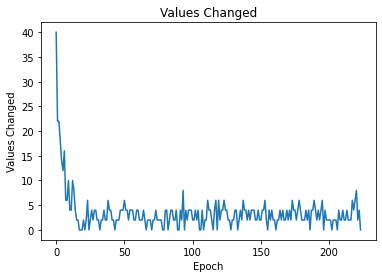

In [21]:
plt.plot(count_list)
plt.title('Values Changed')
plt.xlabel('Epoch')
plt.ylabel('Values Changed')
plt.show()

In [22]:
print(len(full_bmc[1]))

8000


In [23]:
count = 0
average_count = 0
count_list = []
average_list = []

for q in range(len(full_bmc[1])):
  count_list = []
  for i in range(len(full_bmc)):
    count = 0
    for j in range(len(full_bmc[i][q])):     
      if i != len(full_bmc) - 1:
        if full_bmc[i][q][j] != full_bmc[i+1][q][j]:
          count += 1
    count_list.append(count)
  
  average_list.append(count_list)

final_list = []
average_values = []
for i in range(len(average_list[1])):
  for j in range(len(average_list)):
    average_values.append(average_list[j][i])
  final_list.append(statistics.mean(average_values))

print(final_list)

[41.218125, 34.5700625, 30.488541666666666, 25.95534375, 22.491125, 19.701854166666667, 17.82305357142857, 16.168140625, 15.039847222222223, 13.9885375, 13.05971590909091, 12.15228125, 11.551221153846154, 11.065491071428571, 10.539891666666668, 10.0549609375, 9.640625, 9.194104166666667, 8.836427631578948, 8.55514375, 8.271529761904763, 8.059767045454546, 7.838092391304348, 7.618005208333333, 7.409555, 7.224283653846154, 7.08850462962963, 6.927879464285715, 6.77889224137931, 6.673504166666667, 6.5552298387096775, 6.41841796875, 6.309496212121212, 6.207047794117647, 6.122125, 6.034760416666667, 5.953429054054054, 5.865069078947369, 5.75963141025641, 5.695290625, 5.619533536585366, 5.548080357142857, 5.442218023255814, 5.345576704545454, 5.258280555555555, 5.191584239130435, 5.1239867021276595, 5.0796796875, 4.996298469387755, 4.9477825, 4.8890367647058826, 4.832771634615384, 4.779143867924528, 4.7167662037037035, 4.666856818181818, 4.625712053571428, 4.587076754385965, 4.531898706896552

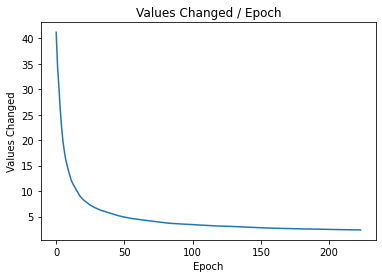

In [24]:
plt.plot(final_list)
plt.title('Values Changed / Epoch')
plt.xlabel('Epoch')
plt.ylabel('Values Changed')
plt.show()

In [25]:
print(len(binary_mask_cache))

0


In [26]:
print(np.mean(acc_cache))

0.8493465401785715


In [27]:
for milestone in summary:
  print(milestone)

Model hit 80% validation accuracy in 20 epochs
Model hit 85% validation accuracy in 24 epochs
Model hit 90% validation accuracy in 25 epochs
Model hit 95% validation accuracy in 29 epochs
Model hit 97.5% validation accuracy in 43 epochs
Max accuracy was 99.85000000000001% at epoch 223.


# Testing

In [28]:
accuracy = Accuracy_Categorical()

accuracy.init(y_test)

dense1.forward(X_test)

activation1.forward(dense1.output)

dropout1.infrence(activation1.output,y_test)

dense2.forward(dropout1.output)

activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

dense4.forward(activation3.output)

activation4.forward(dense4.output)

index = 27
print(f'{(activation4.output[index][np.where(activation4.output[index] == np.amax(activation4.output[index]))][0]*100):.3f}% Confident True is {fashion_mnist_labels[np.where(activation4.output[index] == np.amax(activation4.output[index]))[0][0]]}. True is actually {fashion_mnist_labels[y_test[index]]}')

# Calculate the data loss
loss = loss_function.calculate(activation4.output, y_test)

predictions = activation4.predictions(activation4.output)
testaccuracy = accuracy.calculate(predictions, y_test)

print(f'Accuracy: {testaccuracy:.3f}, loss: {loss:.3f}')

100.000% Confident True is Sneaker. True is actually Sneaker
Accuracy: 0.999, loss: 0.079


In [29]:
training_diff = []
testing_diff = []
combined_diff = []

Individual Training Classes

In [30]:
accuracy = Accuracy_Categorical()

for classes, (X_sorted_lists, y_sorted_lists) in enumerate(zip(sorted_x, sorted_y)):
  accuracy = Accuracy_Categorical()

  y = sorted_y[y_sorted_lists]
  X = sorted_x[X_sorted_lists]
  accuracy.init(y)

  dense1.forward(X)

  activation1.forward(dense1.output)
  train_train_mean = activation1.output

  dropout1.infrence(activation1.output,y)

  dense2.forward(dropout1.output)

  activation2.forward(dense2.output)

  dense3.forward(activation2.output)

  activation3.forward(dense3.output)

  dense4.forward(activation3.output)

  activation4.forward(dense4.output)

  # Calculate the data loss
  loss = loss_function.calculate(activation4.output, y)

  predictions = activation4.predictions(activation4.output)
  testaccuracy = accuracy.calculate(predictions, y)
  print(f'{fashion_mnist_labels[classes]} Train Accuracy: {testaccuracy:.3f}, loss: {loss:.3f}')



T-shirt/top Train Accuracy: 0.995, loss: 0.434
Trouser Train Accuracy: 0.998, loss: 0.007
Pullover Train Accuracy: 1.000, loss: 0.073
Dress Train Accuracy: 1.000, loss: 0.000
Coat Train Accuracy: 0.999, loss: 0.013
Sandal Train Accuracy: 1.000, loss: 0.073
Shirt Train Accuracy: 0.994, loss: 0.049
Sneaker Train Accuracy: 1.000, loss: 0.000
Bag Train Accuracy: 1.000, loss: 0.129
Ankle boot Train Accuracy: 0.994, loss: 0.026


In [31]:
accuracy = Accuracy_Categorical()

for classes, (X_sorted_lists, y_sorted_lists) in enumerate(zip(sorted_x_val, sorted_y_val)):
  accuracy.init(sorted_y_val[y_sorted_lists])
  #print(sorted_y[y_sorted_lists].shape)
  #print(sorted_x[X_sorted_lists].shape)
  dense1.forward(sorted_x_val[X_sorted_lists])

  activation1.forward(dense1.output)

  testmean = np.mean(activation1.output, axis=0)
  testing_diff.append(testmean)
  dropout1.infrence(activation1.output,sorted_y_val[y_sorted_lists])

  dense2.forward(dropout1.output)

  activation2.forward(dense2.output)

  dense3.forward(activation2.output)

  activation3.forward(dense3.output)

  dense4.forward(activation3.output)

  activation4.forward(dense4.output)
  # Calculate the data loss
  loss = loss_function.calculate(activation4.output, sorted_y_val[y_sorted_lists])

  predictions = activation4.predictions(activation4.output)
  testaccuracy = accuracy.calculate(predictions, sorted_y_val[y_sorted_lists])

  print(f'{fashion_mnist_labels[classes]} Test Accuracy: {testaccuracy:.3f}, loss: {loss:.3f}')

T-shirt/top Test Accuracy: 0.999, loss: 0.429
Trouser Test Accuracy: 1.000, loss: 0.006
Pullover Test Accuracy: 0.999, loss: 0.079
Dress Test Accuracy: 1.000, loss: 0.000
Coat Test Accuracy: 1.000, loss: 0.011
Sandal Test Accuracy: 1.000, loss: 0.074
Shirt Test Accuracy: 0.992, loss: 0.041
Sneaker Test Accuracy: 1.000, loss: 0.000
Bag Test Accuracy: 1.000, loss: 0.129
Ankle boot Test Accuracy: 0.991, loss: 0.033


# Full mnist test

Training data

In [32]:
accuracy = Accuracy_Categorical()

accuracy.init(label)

dense1.forward(input)

activation1.forward(dense1.output)
train_train_mean = activation1.output

dropout1.infrence(activation1.output,label)

dense2.forward(dropout1.output)

activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

dense4.forward(activation3.output)

activation4.forward(dense4.output)

# Calculate the data loss
loss = loss_function.calculate(activation4.output, label)

predictions = activation4.predictions(activation4.output)
testaccuracy = accuracy.calculate(predictions, label)

print(f'Found {input.shape[0]} images belonging to {len(set(label))} unique classes')

print(f'Full Training Accuracy: {testaccuracy:.5f}, loss: {loss:.3f}')

Found 60000 images belonging to 10 unique classes
Full Training Accuracy: 0.99785, loss: 0.080


Testing data

In [33]:

(X, y), (X_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

X_val = (X_val.reshape(X_val.shape[0], -1).astype(np.float32) - 127.5) / 127.5 # Reshape X_val if cell below was already ran

accuracy = Accuracy_Categorical()

accuracy.init(y_val)

dense1.forward(X_val)

activation1.forward(dense1.output)

dropout1.infrence(activation1.output,y_val)

dense2.forward(dropout1.output)

activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

dense4.forward(activation3.output)

activation4.forward(dense4.output)


# Calculate the data loss
loss = loss_function.calculate(activation4.output, y_val)
predictions = activation4.predictions(activation4.output)
testaccuracy = accuracy.calculate(predictions, y_val)

print(f'Found {X_val.shape[0]} images belonging to {len(set(y_val))} unique classes')
print(f'Full Testing Accuracy: {testaccuracy:.5f}, loss: {loss:.3f}')

Found 10000 images belonging to 10 unique classes
Full Testing Accuracy: 0.99810, loss: 0.080


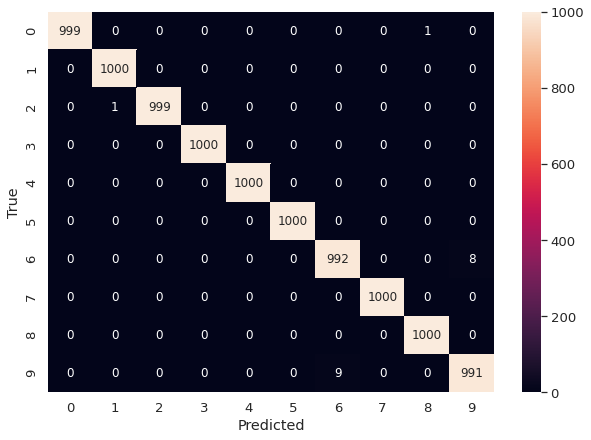

              precision    recall  f1-score   support

 T-shirt/top       1.00      1.00      1.00      1000
     Trouser       1.00      1.00      1.00      1000
    Pullover       1.00      1.00      1.00      1000
       Dress       1.00      1.00      1.00      1000
        Coat       1.00      1.00      1.00      1000
      Sandal       1.00      1.00      1.00      1000
       Shirt       0.99      0.99      0.99      1000
     Sneaker       1.00      1.00      1.00      1000
         Bag       1.00      1.00      1.00      1000
  Ankle boot       0.99      0.99      0.99      1000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [34]:
predicted_list = []
true_list = []
for sample in range(len(X_val)):
  predicted_list.append(fashion_mnist_labels[np.where(activation4.output[sample] == np.amax(activation4.output[sample]))[0][0]])
  true_list.append(fashion_mnist_labels[y_val[sample]])

from sklearn import metrics

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = metrics.confusion_matrix(true_list, predicted_list, labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

df_cm = pd.DataFrame(array, range(len(set(true_list))), range(len(set(true_list))))
df_cm.round(9)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Printing the precision and recall, among other metrics
print(metrics.classification_report(true_list, predicted_list, labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']))

In [35]:
for index in range(10000):
  if y_val[index] != np.where(activation4.output[index] == np.amax(activation4.output[index]))[0][0]:
    print(index)

1645
1907
2447
2551
3130
3880
4497
4615
4743
5248
5249
5512
6452
6596
7800
8211
8763
9474
9674


Change idex to get confidence of different samples of testing data. Index values 0-1600 were refrenced in training. Anything past was never seen during training. Lowest confidence is at index 2732 when trained with 488 epochs and numpy seed set to 22.

96.139% Confident True is Shirt. True is actually Shirt


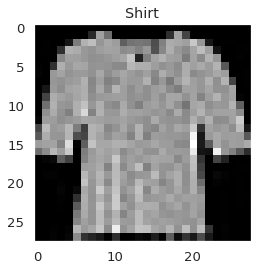

In [36]:
index = 5674

print(f'{(activation4.output[index][np.where(activation4.output[index] == np.amax(activation4.output[index]))][0]*100):.3f}% Confident True is {fashion_mnist_labels[np.where(activation4.output[index] == np.amax(activation4.output[index]))[0][0]]}. True is actually {fashion_mnist_labels[y_val[index]]}')

X_val.resize(X_val.shape[0],28,28)
image = X_val[index]
plt.rcParams['axes.grid'] = False
fig = plt.figure
plt.title(f'{fashion_mnist_labels[y_val[index]]}')
plt.imshow(image, cmap='gray')
plt.show()

In [37]:
confidence_list = []
for index in range(10000):
  confidence_list.append(activation4.output[index][np.where(activation4.output[index] == np.amax(activation4.output[index]))][0])

print(confidence_list.index(min(confidence_list)))

a = confidence_list[:] 
a.sort()
print(confidence_list.index(a[1]))

7818
5710


Plotting Graphs

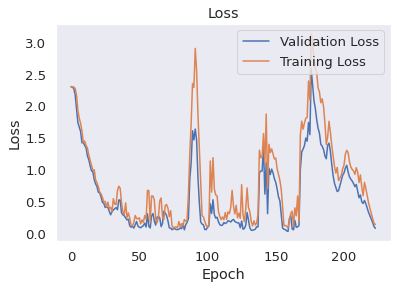

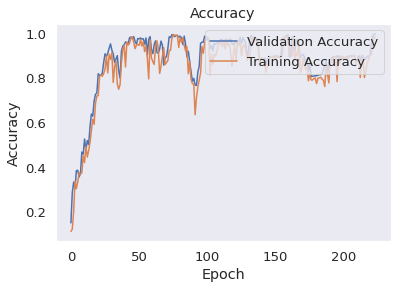

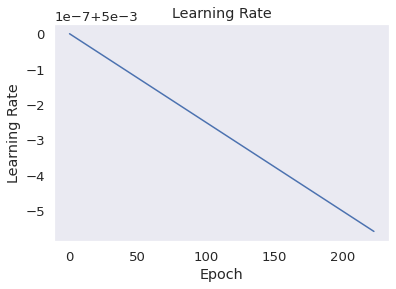

In [38]:
plt.plot(epoch_cache, val_loss_cache, label='Validation Loss')
plt.plot(epoch_cache, loss_cache, label='Training Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.show()

plt.plot(epoch_cache, val_acc_cache, label='Validation Accuracy')
plt.plot(epoch_cache, acc_cache, label='Training Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = "upper right")
plt.show()

plt.plot(epoch_cache, lr_cache, label='LR')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()